<a href="https://colab.research.google.com/github/Pinkysol/Learning/blob/22/22_3_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%95%D0%BC%D0%B5%D0%BB%D1%8C%D1%8F%D0%BD%D0%BE%D0%B2_%D0%94_%D0%90_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Навигация по уроку**

1. [Решение задач регрессии с помощью НС](https://colab.research.google.com/drive/1GbXbqPbC4A2NVJEj-5pOOySN3gyalBQN)
2. [Анализ резюме кандидатов](https://colab.research.google.com/drive/1L4pI4giYvWY3T4gfqTF5c_XFkN9k4Nfz)
3. Домашняя работа

**В домашней работе необходимо выполнить следующее задание:**

1. Используя предложенный [датасет](https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv) японских машин, обучите модель предсказывать цены на японские автомобили.
2. Создайте обучающую, тестовую и проверочную выборки.
3. Оцените качество работы созданной сети, определите средний процент ошибки на проверочной выборке.
4. В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
5. Выполнив задание, получите 3 балла.
6. Хотите 4 балла? Добейтесь ошибки менее 10%.
7. Хотите 5 баллов? Добейтесь ошибки менее 5%.


**Примечание**. Подробную информацию о датасете можно узнать на портале соревновани [kaggle.com](https://www.kaggle.com/datasets/doaaalsenani/used-cars-dataets/data).



In [1]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2025-02-13 18:22:47--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv.110’

japan_cars_dataset. 100%[===================>] 133.53K   737KB/s    in 0.2s    

2025-02-13 18:22:47 (737 KB/s) - ‘japan_cars_dataset.csv.110’ saved [136735/136735]



In [2]:
# Для работы с массивами данных
import numpy as np

# Для работы с табличными данными
import pandas as pd

# Библиотека утилит
from keras import utils

# Для работы с моделями
from keras.models import Sequential, Model

# Слои
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор
from tensorflow.keras.preprocessing.text import Tokenizer

# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Регулярные выражения
import re

# Для работы с графиками
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib inline

2025-02-13 18:22:48.466206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 18:22:48.541560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('japan_cars_dataset.csv', sep=',')

# Удалим строки с пустыми значениями
df = df.dropna()
df.drop(['Unnamed: 0'], inplace=True, axis=1)

# Выводим первые 10 машин
df = df.sample(frac=1, random_state=42)
df.head(10)

,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
1040,950,nissan,tiida,2011,73000,1500,at,2wd,rhd,gasoline
548,760,honda,fit,2005,78000,1330,at,2wd,rhd,gasoline
100,400,daihatsu,tanto,2012,183800,660,at,2wd,rhd,gasoline
1044,950,toyota,brevis,2001,76000,2990,at,2wd,rhd,gasoline
251,560,honda,fit,2004,74200,1300,at,2wd,rhd,gasoline
482,728,suzuki,swift,2007,50775,1300,at,2wd,rhd,gasoline
1556,1150,volkswagen,polo,2008,70000,1600,at,2wd,rhd,gasoline
2077,1320,nissan,ad,2013,164000,1490,at,2wd,rhd,gasoline
179,498,nissan,x-trail,2005,115934,1990,at,2wd,rhd,gasoline
1615,1180,toyota,voxy,2007,81000,2000,at,2wd,rhd,gasoline


In [4]:
def str2multiOHE(param, class_dict):

    # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(set(class_dict.values()))

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Если не смогли распарсить, то поле не заполнено
    # Устанавливаем значение по умолчанию (последний элемент в словаре)
    if not isinstance(param, str):
        param = list(class_dict.keys())[-1]

    # Поиск значения в словаре и, если нашли, то проставляем 1 в найденной позиции
    for value, cls in class_dict.items():
        if value in param:
            result[cls] = 1.

    return result

def range2OHE(param, class_list):

   # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(class_list) + 1

    # Поиск интервала для входного значения
    for i in range(num_classes - 1):
        if float(param) < class_list[i]:
            cls = i                       # Интервал найден, выбор класса
            break
    else:
        cls = num_classes - 1             # Интервал не найден, выбор последнего класса

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [5]:
# Создание массивов уникальных значений
year_class = [1990, 1995, 2000, 2005, 2010, 2015]
transmission_class = {x: i for i,x in enumerate(df["transmission"].unique())}
drive_class = {x: i for i,x in enumerate(df["drive"].unique())}
drive_class['awd'] = 1
hand_drive_class = {x: i for i,x in enumerate(df["hand_drive"].unique())}
fuel_class = {x: i for i,x in enumerate(df["fuel"].unique())}
mark_class = {x: i for i,x in enumerate(df["mark"].unique())}
model_class = {x: i for i,x in enumerate(df["model"].unique())}

In [6]:
# Фиксация индексов столбцов
COL_YEAR            = df.columns.get_loc('year')
COL_PRICE           = df.columns.get_loc('price')
COL_MARK            = df.columns.get_loc('mark')
COL_MODEL           = df.columns.get_loc('model')
COL_TRANSMISSION    = df.columns.get_loc('transmission')
COL_DRIVE           = df.columns.get_loc('drive')
COL_HAND_DRIVE      = df.columns.get_loc('hand_drive')
COL_FUEL            = df.columns.get_loc('fuel')

def get_row_data(row):
    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([
                range2OHE(row[COL_YEAR], year_class),
                str2multiOHE(row[COL_MARK], mark_class),
                str2multiOHE(row[COL_MODEL], model_class),
                str2multiOHE(row[COL_TRANSMISSION], transmission_class),
                str2multiOHE(row[COL_DRIVE], drive_class),
                str2multiOHE(row[COL_HAND_DRIVE], hand_drive_class),
                str2multiOHE(row[COL_FUEL], fuel_class)
              ])

    y_data = np.array([row[COL_PRICE]])

    return x_data, y_data

def get_train_data(dataFrame):
    x_data = []
    y_data = []

    for row in dataFrame.values:
        x, y = get_row_data(row)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)


In [7]:
# Формирование выборки из загруженного набора данных
x_train, y_train = get_train_data(df)

In [8]:
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

In [9]:
input1 = Input((x_train.shape[1],))

# Первый вход для числовых данных
x = input1
x = Dense(20, activation="relu")(x)
x = Dense(500, activation="relu")(x)
x = Dense(200, activation="relu")(x)

# Промежуточный слой
x = Dense(30, activation='relu')(x)
x = Dropout(0.5)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input1), x)

2025-02-13 18:22:50.571426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-13 18:22:50.585153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-13 18:22:50.585199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-13 18:22:50.597241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-13 18:22:50.597355: I external/local_xla/xla/stream_executor

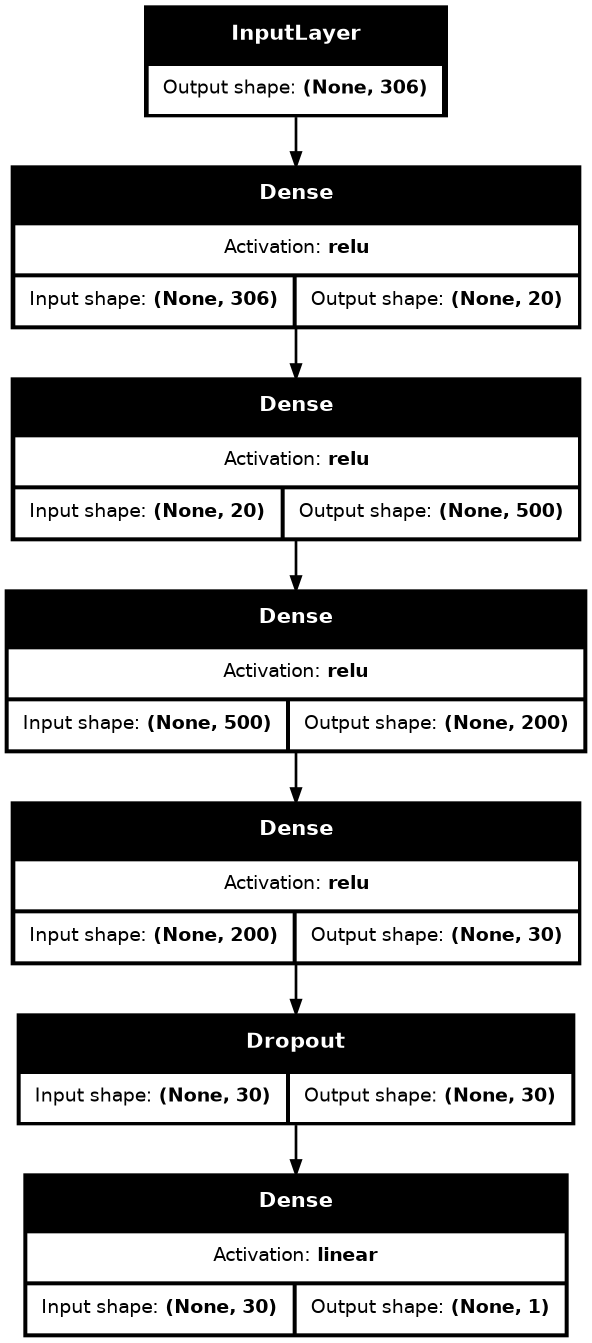

In [10]:
utils.plot_model(model, dpi=96, show_shapes=True, show_layer_activations=True)

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit(x_train[:2000],
                           y_train_scaled[:2000],
                           batch_size=256,
                           epochs=500,
                           validation_data=(x_train[2000:2200], y_train_scaled[2000:2200]),
                           verbose=1)

Epoch 1/500


I0000 00:00:1739445772.144685  425566 service.cc:145] XLA service 0x7f29e4015660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739445772.144803  425566 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-13 18:22:52.164916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-13 18:22:52.277434: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1739445772.786560  425637 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_200', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1739445773.366831  425641 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_200', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:

1/8 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 0.9717 - mae: 0.8271

I0000 00:00:1739445776.579570  425566 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1739445777.208845  425778 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_193', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1739445777.450138  425780 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_193', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1739445777.629574  425775 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_200', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1739445777.683471  425782 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_200', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1739445777.738444  425785 asm_compiler.cc:369] ptxas warning : R

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - loss: 0.9786 - mae: 0.8267

I0000 00:00:1739445781.594733  425945 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1739445781.661975  425946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1739445781.927568  425949 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_35', 484 bytes spill stores, 484 bytes spill loads

I0000 00:00:1739445782.293521  425952 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_35', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1739445782.402180  425946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_35', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1739445782.581950  425955 asm_

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 940ms/step - loss: 0.9819 - mae: 0.8284 - val_loss: 0.9895 - val_mae: 0.8497
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9970 - mae: 0.8387 - val_loss: 0.9888 - val_mae: 0.8495
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0163 - mae: 0.8510 - val_loss: 0.9881 - val_mae: 0.8492
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9939 - mae: 0.8369 - val_loss: 0.9874 - val_mae: 0.8490
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0270 - mae: 0.8560 - val_loss: 0.9868 - val_mae: 0.8487
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0071 - mae: 0.8389 - val_loss: 0.9861 - val_mae: 0.8485
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0029 - mae: 0.8437 - val_loss: 0.9854 - val_mae: 0.8482
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9931 - mae: 0.8371 - val_loss: 0.9848 - val_mae: 0.8480
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0262 - mae: 0.8493 - val_loss:

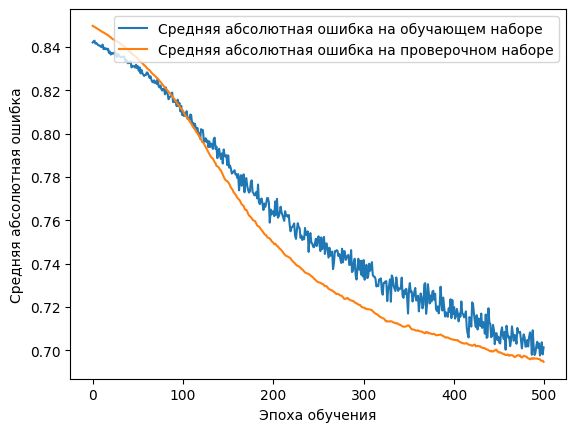

In [12]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

I0000 00:00:1739445819.373947  454006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 4 bytes spill stores, 4 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step
Средняя абсолютная ошибка: 218.7523193359375 

Средняя квадратичная ошибка: 68844.9296875 

Средняя абсолютная процентная ошибка: 0.2568018436431885 

Реальное значение: 1166.00  Предсказанное значение: 936.24  Разница: 229.76
Реальное значение: 1240.00  Предсказанное значение: 966.36  Разница: 273.64
Реальное значение: 1213.00  Предсказанное значение: 958.82  Разница: 254.18
Реальное значение: 1010.00  Предсказанное значение: 781.20  Разница: 228.80
Реальное значение: 961.00  Предсказанное значение: 1098.99  Разница: 137.99
Реальное значение: 760.00  Предсказанное значение: 1052.52  Разница: 292.52
Реальное значение: 1200.00  Предсказанное значение: 1013.19  Разница: 186.81
Реальное значение: 1220.00  Предсказанное значение: 1096.70  Разница: 123.30
Реальное значение: 1283.00  Предсказанное значение: 781.20  Разница: 501.80
Реальное значение: 400.00  Предсказанное значение: 662.27  Разница: 262.27


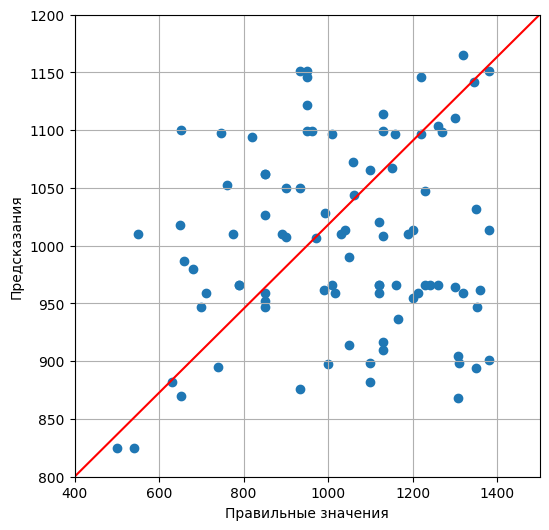

In [13]:
pred = model.predict(x_train[2200:])  # Предсказание на новых данных (контрольный образец)

pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура

print('Средняя абсолютная ошибка:', mean_absolute_error(y_train[2200:], pred), '\n') # расчет средней абсолютной ошибки
print('Средняя квадратичная ошибка:', mean_squared_error(y_train[2200:], pred), '\n') # расчет средней квадратичной ошибки
print('Средняя абсолютная процентная ошибка:', mean_absolute_percentage_error(y_train[2200:], pred), '\n') # расчет абсолютной процентной ошибки

for i in range(10):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[2200:][i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_train[2200:][i, 0] - pred[i, 0])))
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_train[2200:], pred)          # Отрисовка точечного графика
ax.set_xlim(400, 1500)                           # Ограничение оси по x
ax.set_ylim(800, 1200)                           # Ограничение оси по x
ax.plot(plt.xlim(), plt.ylim(), 'r')          # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()